# Exercise 2 – Determining the spreading of epidemics

### Federico Agostini, Federico Bottaro, Gianmarco Pompeo 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
from scipy import stats
from scipy.stats import norm


In [2]:
# create adjacency matrix for network A
index_i_A, index_j_A = np.loadtxt("net1.txt", dtype=np.int, unpack=True)
dim = max(index_i_A.max(), index_j_A.max())+1
NetA_matrix = np.zeros((dim, dim))
for i,j in zip(index_i_A, index_j_A):
    # the adjacency matrix needs to be symmetric
    NetA_matrix[i, j] = 1
    NetA_matrix[j, i] = 1

In [3]:
# create adjacency matrix for network B
index_i_B, index_j_B = np.loadtxt("net2.txt", dtype=np.int16, unpack=True)
dim = max(index_i_B.max(), index_j_B.max())+1
NetB_matrix = np.zeros((dim, dim))
for i,j in zip(index_i_B, index_j_B):
    # the adjacency matrix needs to be symmetric
    NetB_matrix[i, j] = 1
    NetB_matrix[j, i] = 1

In [4]:
NetA = nx.from_numpy_array(NetA_matrix)
NetB = nx.from_numpy_array(NetB_matrix)

D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


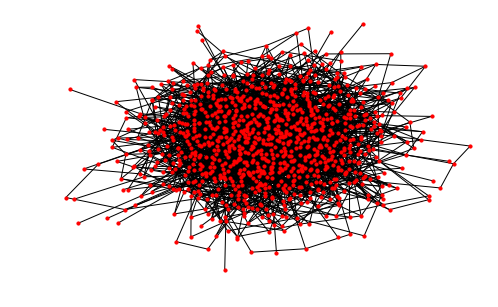

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
nx.draw(NetA, node_size=10, ax=ax)
#fig.tight_layout()
#fig.savefig("./Figure/NetA_graph.pdf")

D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


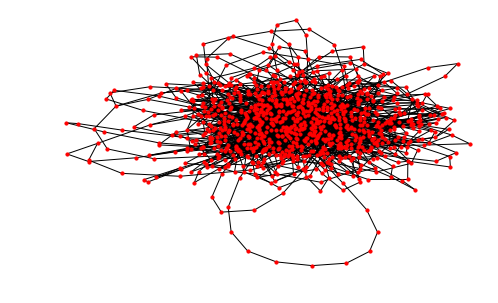

In [6]:
fig, ax = plt.subplots(figsize=(8,5))
nx.draw(NetB, node_size=10, ax=ax)
#fig.tight_layout()
#fig.savefig("./Figure/NetB_graph.pdf")

## Task 1
Using the two networks provided in (A), calculate the epidemic threshold in the **SIS** dynamics for the homogenous, heterogenous and quenched mean-field approximations for $\mu=0.5$

In [7]:
# Preliminaries

mu = 0.5

## Average degree

### Network A
node_deg = NetA.degree()
node_deg = list(node_deg)
NetA_degree = np.array([x[1] for x in node_deg])
NetA_average_degree   = NetA_degree.mean() # <k_A>
NetA_average_degree_2 = np.mean(np.power(NetA_degree, 2)) # <(k_A)**2>
NetA_max_eigenvalue = np.max(np.real(np.linalg.eig(NetA_matrix)[0]))
print(NetA_max_eigenvalue)

### Network B
node_deg = NetB.degree()
node_deg = list(node_deg)
NetB_degree = np.array([x[1] for x in node_deg])
NetB_average_degree   = NetB_degree.mean() # <k_B>
NetB_average_degree_2 = np.mean(np.power(NetB_degree, 2)) # <(k_B)**2>
NetB_max_eigenvalue = np.max(np.real(np.linalg.eig(NetB_matrix)[0]))
print(NetB_max_eigenvalue)

6.284102805703304
7.530166187718354


In [8]:
# Homogeneus MF
NetA_lambda_MF = mu/NetA_average_degree
NetB_lambda_MF = mu/NetB_average_degree
print("HOMOGENEOUS MF")
print("Lambda_A =", NetA_lambda_MF)
print("Lambda_B =", NetB_lambda_MF)

HOMOGENEOUS MF
Lambda_A = 0.0971628449280995
Lambda_B = 0.13919821826280623


In [9]:
# Heterogeneous MF
NetA_lambda_HMF = mu*NetA_average_degree/NetA_average_degree_2
NetB_lambda_HMF = mu*NetB_average_degree/NetB_average_degree_2
print("HETEROGENEUOS MF")
print("Lambda_A =", NetA_lambda_HMF)
print("Lambda_B =", NetB_lambda_HMF)

HETEROGENEUOS MF
Lambda_A = 0.08160482080558198
Lambda_B = 0.07587663709336713


In [10]:
# Quenched MF
NetA_lambda_QMF = mu/NetA_max_eigenvalue
NetB_lambda_QMF = mu/NetB_max_eigenvalue
print("QUENCHED MF")
print("Lambda_A =", NetA_lambda_QMF)
print("Lambda_B =", NetB_lambda_QMF)

QUENCHED MF
Lambda_A = 0.07956585298798928
Lambda_B = 0.06639959697244084


## Task 2
Implement the (stochastic) SIS model in the two networks and simulate the entire phase diagram for $\mu=0.5$. Compare the three theoretical thresholds with the numerical results. 

*Suggestion: you need to simulate many (e.g. 100) simulations for each network and compare mean and std with the different analytical approximations.*

$$a_1 = \mu I$$
$$a_2 = \lambda n\,,$$ where $n$ is the number of links S -- I

In [11]:
np.random.seed(20190410)

In [12]:
def Gillespie(net, netName="test", lambdas=np.linspace(0.05,1, 50), mu=0.5, infects=50, n_steps=3000, N_rep=100):
    netmat = nx.to_numpy_matrix(net)
    net = nx.from_numpy_array(netmat)
    dim = net.number_of_nodes()
    # get edge list (two arrays: index_i--index_j)
    ed_list = nx.generate_edgelist(net, data=False) ########MODIFICATO
    index_i, index_j = [], []
    for line in ed_list:
        index_i.append(int(line.split()[0]))
        index_j.append(int(line.split()[1]))
    index_i = np.array(index_i)
    index_j = np.array(index_j)
    
    lambda_mean_list=[]
    lambda_std_list=[]

    for number,l in enumerate(lambdas):
        print("***lambda =", l)
        iter_matrix=[]
        for repetition in range(N_rep):

            state = np.zeros(dim)
            # put Infected in the network
            state[np.random.choice(dim, infects, replace=False)] = 1
            I_number = [infects]

            link_matrix = np.zeros((dim,dim))
            for i,j in zip(index_i, index_j):
                if state[i] == state[j]:
                    link_matrix[i,j] = 0
                    link_matrix[j,i] = 0
                else:
                    link_matrix[i,j] = 1
                    link_matrix[j,i] = 1

            for steps in range(n_steps):
                n_I = state.sum() # #Infected
                n_S = dim - n_I   # #Susceptible
                n_N = dim
                link_sum = 0.5*link_matrix.sum()
                a1  = mu*n_I
                a2  = l*link_sum#l*n_I*n_S/N_n
                a0  = a1+a2
                p_a1= a1/a0
                # select the reaction
                # reaction 1
                if np.random.rand() < p_a1:
                    # select I at random
                    I_index    = np.where(state == 1)[0]
                    I_selected = np.random.choice(I_index)
                    #print("I_selected =", I_selected)
                    # I -> S
                    state[I_selected] = 0
                    neighbours = np.array([n for n in net.neighbors(I_selected)])
                    for Nn in neighbours:
                        if state[I_selected] == state[Nn]:
                            link_matrix[I_selected,Nn] = 0
                            link_matrix[Nn,I_selected] = 0
                        else:
                            link_matrix[I_selected,Nn] = 1
                            link_matrix[Nn,I_selected] = 1

                # reaction 2
                else:
                    # select I at random
                    I_index = np.where(state == 1)[0]
                    np.random.shuffle(I_index)

                    for k in I_index:
                        # get list of neighbours
                        neighbours = np.array([n for n in net.neighbors(k)])
                        # if the node is isolated, search for another one
                        if len(neighbours) == 0: continue
                        nn_infected = state[neighbours].sum()
                        if nn_infected == len(neighbours): 
                            continue
                        else:
                            np.random.shuffle(neighbours)
                            for NNs in neighbours:
                                if state[NNs] == 0:
                                    state[NNs] = 1

                                    NNNeighbours = np.array([n for n in net.neighbors(NNs)])
                                    for VIC in NNNeighbours:
                                        if state[NNs] == state[VIC]:
                                            link_matrix[NNs,VIC] = 0
                                            link_matrix[VIC,NNs] = 0
                                        else:
                                            link_matrix[NNs,VIC] = 1
                                            link_matrix[VIC,NNs] = 1
                                    break
                            break
                I_number.append(state.sum())  
            iter_matrix.append(I_number)
        filename = netName+"/iterations/"+str(number)+".gz"
        iter_matrix = np.array(iter_matrix)
        np.savetxt(filename, iter_matrix)
        lambda_mean_list.append(iter_matrix.mean(axis=0))
        lambda_std_list.append(iter_matrix.std(axis=0))
    np.savetxt(netName+"/mean.gz", np.array(lambda_mean_list))
    np.savetxt(netName+"/std.gz", np.array(lambda_std_list))
    return lambda_mean_list, lambda_std_list

In [13]:
def LambdaInterpolation(lambda_mean_list, lambdas=np.linspace(0.05,1, 50), n_I=1000, n_mean=500, figname="test"):    
    lambda_mean_list = lambda_mean_list/n_I
    I_final=[]
    #I_final_errors=[]
    for i in lambda_mean_list:
        I_temp=i[-n_mean:]
        I_final.append(I_temp.mean())
        #I_final_errors.append((I_temp.std()/n_mean)**0.5)

    Interpolation = np.array([lambdas[3:6],I_final[3:6]])
    x=Interpolation[0]
    y=Interpolation[1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    X=np.linspace(0.05,0.6,50)
    Y=slope*X + intercept

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(lambdas,I_final,"*",color="blue")
    ax.plot(Interpolation[0],Interpolation[1],"*",color="red")
    ax.plot(X,Y,":")
    ax.axhline(y=0,linestyle=":")
    ax.set_ylim(-0.05,1)

    ax.set_xlabel("$\lambda$", fontsize=14)
    ax.set_ylabel("Fraction of infected", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    fig.tight_layout()
    fig.savefig("./Figure/"+figname+"_lambdas.pdf")

    Lambda_crit= - intercept/slope
    print("\n***"+figname+"***")
    print("Lambda_crit =",Lambda_crit)

In [14]:
# Network A
net_list_A = [NetA]

NetA_copy = NetA.copy()

for i in range(10):
    node_deg = NetA_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetA_copy.remove_node(np.argmax(Net_degree))
    
net_list_A.append(NetA_copy)

NetA_copy = NetA.copy()

for i in range(10):
    node_bet = list(nx.betweenness_centrality(NetA_copy).values())
    NetA_copy.remove_node(np.argmax(node_bet))
    
net_list_A.append(NetA_copy)

NetA_copy = NetA.copy()

for i in range(5):
    node_deg = NetA_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetA_copy.remove_node(np.argmax(Net_degree))
for i in range(5):
    node_bet = list(nx.betweenness_centrality(NetA_copy).values())
    NetA_copy.remove_node(np.argmax(node_bet))

net_list_A.append(NetA_copy)

net_list_A_name = ["NetA", "NetA_rm10deg", "NetA_rm10bet", "NetA_rm5deg5bet"]



***NetA***
Lambda_crit = 0.09512094732328627

***NetA_rm10deg***
Lambda_crit = 0.09687488322803194

***NetA_rm10bet***
Lambda_crit = 0.09562755136028683

***NetA_rm5deg5bet***
Lambda_crit = 0.09631605001263893


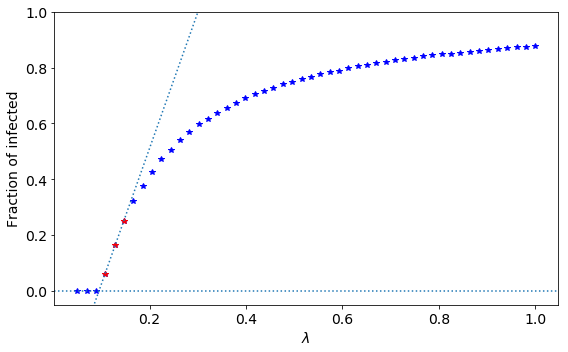

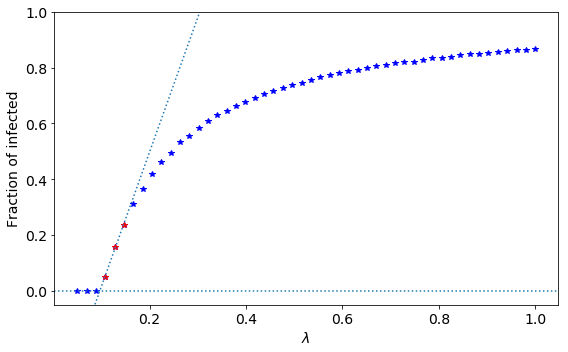

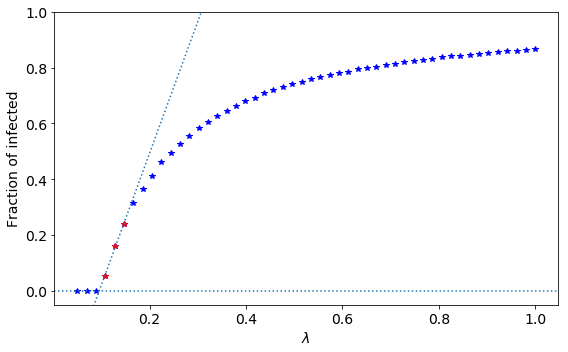

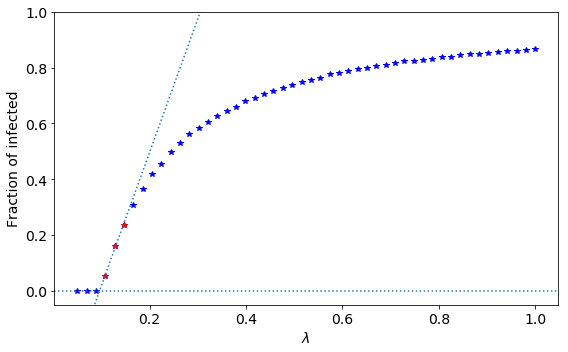

In [15]:
for Dir in net_list_A_name:
    data = np.loadtxt(Dir+"/mean.gz")
    LambdaInterpolation(lambda_mean_list=data, figname=Dir)

In [16]:
# Network B
net_list_B = [NetB]

NetB_copy = NetB.copy()

for i in range(10):
    node_deg = NetB_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetB_copy.remove_node(np.argmax(Net_degree))
    
net_list_B.append(NetB_copy)

NetB_copy = NetB.copy()

for i in range(10):
    node_bet = list(nx.betweenness_centrality(NetB_copy).values())
    NetB_copy.remove_node(np.argmax(node_bet))
    
net_list_B.append(NetB_copy)

NetB_copy = NetB.copy()

for i in range(5):
    node_deg = NetB_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetB_copy.remove_node(np.argmax(Net_degree))
for i in range(5):
    node_bet = list(nx.betweenness_centrality(NetB_copy).values())
    NetB_copy.remove_node(np.argmax(node_bet))

net_list_B.append(NetB_copy)

net_list_B_name = ["NetB", "NetB_rm10deg", "NetB_rm10bet", "NetB_rm5deg5bet"]



***NetB***
Lambda_crit = 0.0948580089243514

***NetB_rm10deg***
Lambda_crit = 0.10924276880429117

***NetB_rm10bet***
Lambda_crit = 0.09804093337784398

***NetB_rm5deg5bet***
Lambda_crit = 0.1079427042610082


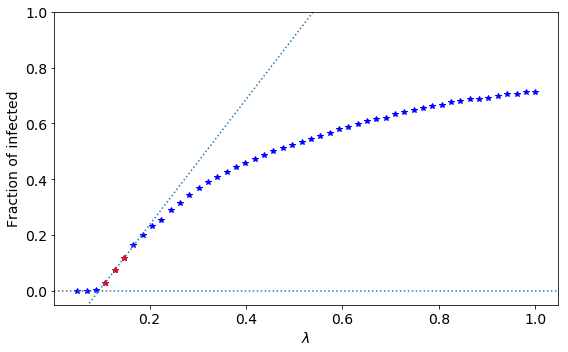

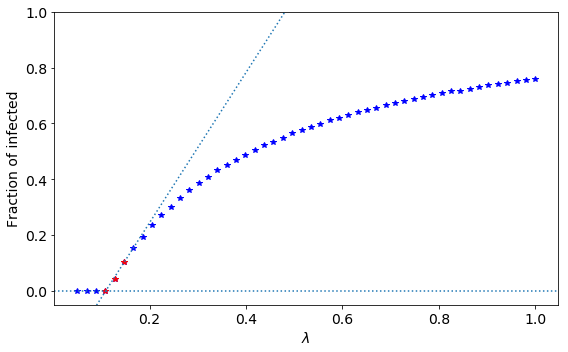

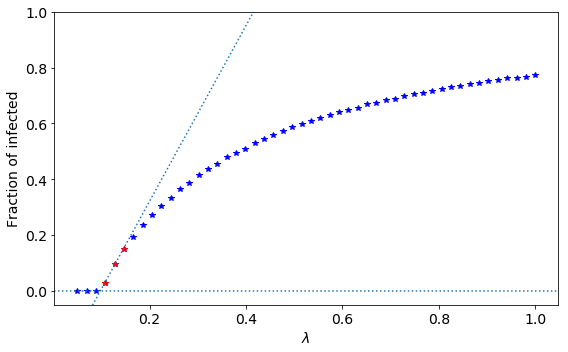

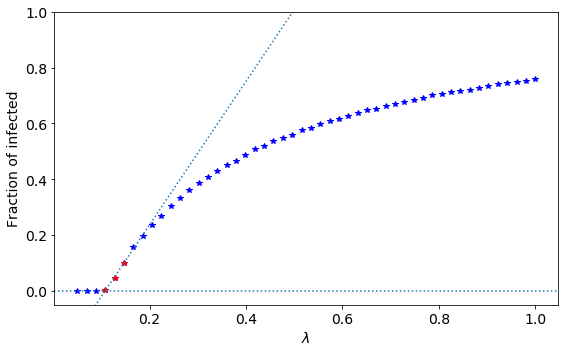

In [17]:
for Dir in net_list_B_name:
    data = np.loadtxt(Dir+"/mean.gz")
    LambdaInterpolation(lambda_mean_list=data, figname=Dir)

## Task 3
Characterize the two networks in terms of their connectivity, degree distribution, page-rank distribution, clustering coefficient. Comment the results at the light of point 2 (e.g. how structural properties of the networks and results of the epidemic dynamics are related?)

In [18]:
'''connected component'''
print("number of connected component:")
print("Network A: ",nx.number_connected_components(NetA))
print("Network B: ",nx.number_connected_components(NetB))

number of connected component:
Network A:  1
Network B:  1


In [19]:
'''edge_connectivity'''
print("edge_connectivity")
print("Network A: ",nx.edge_connectivity(NetA))
print("Network B: ",nx.edge_connectivity(NetB))

edge_connectivity
Network A:  1
Network B:  2


In [20]:
'''connectivity'''
link_A=NetA.number_of_edges()
link_B=NetB.number_of_edges()
node_A=NetA.number_of_nodes()
node_B=NetB.number_of_nodes()
conn_A=link_A/(node_A*(node_A-1)/2)
conn_B=link_B/(node_B*(node_B-1)/2)
print("connectivity")
print("Network A: ",conn_A)
print("Network B: ",conn_B)

connectivity
Network A:  0.005151151151151151
Network B:  0.0035955955955955955


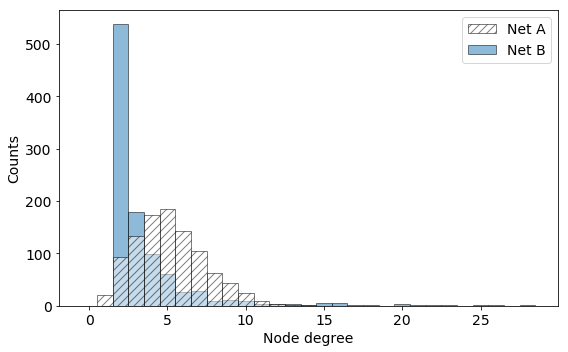

In [21]:
'''node degree'''
node_deg = NetA.degree()
node_deg = list(node_deg)
degA = np.array([x[1] for x in node_deg])

node_deg = NetB.degree()
node_deg = list(node_deg)
degB = np.array([x[1] for x in node_deg])

# plot the node degree distribution as histogram
bins = [x for x in range(np.max([degA.max(), degB.max()]))]
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(degA, bins=bins, histtype='bar', ec='black', zorder=10, alpha=.5, align="left", hatch="///", color="white", label="Net A")
ax.set_xlabel("Node degree", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
#plt.show()

# plot the node degree distribution as histogram
#fig, ax = plt.subplots(figsize=(8,5))
ax.hist(degB, bins=bins, histtype='bar', ec='black', alpha=.5, align="left", label="Net B")
ax.set_xlabel("Node degree", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
plt.legend(fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/Node_degree.pdf")
plt.show()

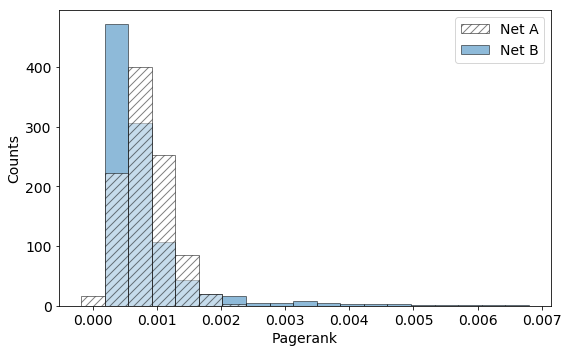

In [22]:
'''pagerank'''
pagerankA = np.array(list(nx.pagerank(NetA).values()))
pagerankB = np.array(list(nx.pagerank(NetB).values()))

fig, ax = plt.subplots(figsize=(8,5))
bins = np.linspace(0, np.max([pagerankA.max(), pagerankB.max()]), 20)
ax.hist(pagerankA, bins=bins, histtype='bar', ec='black', zorder=10, alpha=.5, align="left", hatch="///", color="white", label="Net A")
ax.set_xlabel("pagerank", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()


#fig, ax = plt.subplots(figsize=(8,5))
ax.hist(pagerankB, bins=bins, histtype='bar', ec='black', alpha=.5, align="left", label="Net B")
ax.set_xlabel("Pagerank", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
plt.legend(fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/Pagerank.pdf")
plt.show()


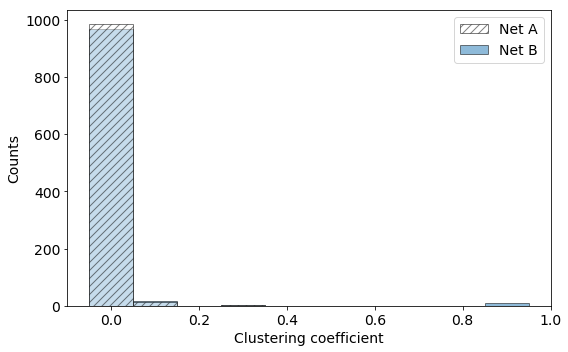

In [23]:
'''clustering coefficient'''
cluster_coeff = nx.clustering(NetA)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(cluster_coeff.values(), histtype='bar', ec='black', zorder=10, alpha=.5, align="left", hatch="///", color="white", label="Net A")
ax.set_xlabel("Clustering coefficient", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
#plt.show()

cluster_coeff = nx.clustering(NetB)
#fig, ax = plt.subplots(figsize=(8,5))
ax.hist(cluster_coeff.values(), histtype='bar', ec='black', alpha=.5, align="left", label="Net B")
ax.set_ylabel("Counts", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
ax.legend(fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/Clustering_coeff.pdf")
plt.show()

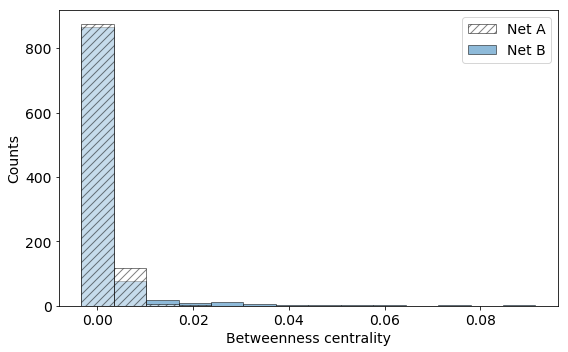

In [24]:
'''betweenness centrality'''
bet_centrA = np.array(list(nx.betweenness_centrality(NetA).values()))
bet_centrB = np.array(list(nx.betweenness_centrality(NetB).values()))
bins = np.linspace(0, np.max([bet_centrA.max(), bet_centrB.max()]), 15)

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(bet_centrA, bins=bins, histtype='bar', ec='black', zorder=10, alpha=.5, align="left", hatch="///", color="white", label="Net A")
ax.set_xlabel("Betweenness centrality", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()

ax.hist(bet_centrB, bins=bins, histtype='bar', ec='black', alpha=.5, align="left", label="Net B")
ax.set_ylabel("Counts", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
ax.legend(fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/Betweenness_centrality.pdf")
plt.show()

D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


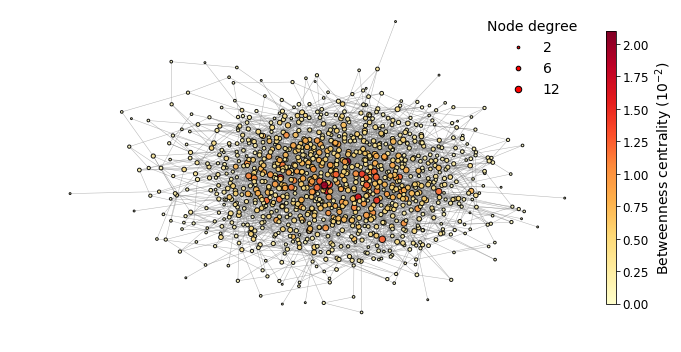

In [25]:
# Network A
# draw the network graph with a nicer plot
fig, ax = plt.subplots(figsize=(10,5))
node_deg = NetA.degree()
node_deg = list(node_deg)
deg = [x[1] for x in node_deg]
bet_centr = nx.betweenness_centrality(NetA)
bet_centr = np.array(list(bet_centr.values()))*100
vmin = np.min(bet_centr)
vmax = np.max(bet_centr)
cmap = plt.cm.YlOrRd
pos  = nx.spring_layout(G=NetA)
#nx.draw_networkx(G=g, node_size=500, ax=ax, node_color=deg, edge_color="#d1d1d1", alpha=.8,
#                 with_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, width=.5, linewidths=1.5)
nx.draw_networkx_edges(G=NetA, pos=pos, ax=ax, width=.5, edge_color="gray", alpha=.6)
nx.draw_networkx_nodes(G=NetA, pos=pos, ax=ax, node_size=np.array(deg)*3.5, node_color=bet_centr, alpha=.9, cmap=cmap, vmin=vmin, vmax=vmax, edgecolors="k")
ax.axis("off")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=.85, aspect=30, pad=.025)
cbar.set_label("Betweenness centrality ($10^{-2}$)", fontsize=14)
cbar.ax.tick_params(labelsize=12)
msizes = np.array([2,6,12])
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size*3.5, label=size, color="red", edgecolor="k"))
plt.legend(handles=markers, loc="best", fontsize=14, title="Node degree", title_fontsize=14, frameon=False)
fig.tight_layout()
fig.savefig("./Figure/NetA_graph.pdf")

D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


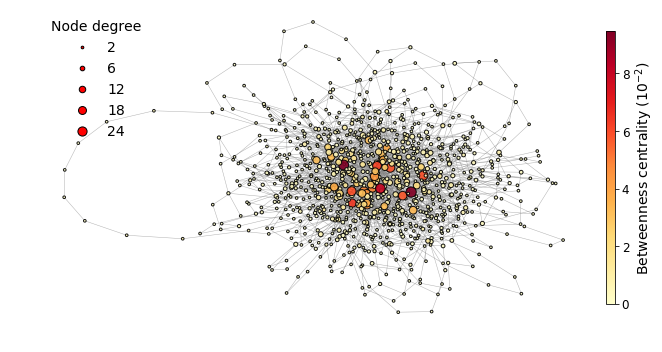

In [26]:
# Network B
# draw the network graph with a nicer plot
fig, ax = plt.subplots(figsize=(10,5))
node_deg = NetB.degree()
node_deg = list(node_deg)
deg = [x[1] for x in node_deg]
bet_centr = nx.betweenness_centrality(NetB)
bet_centr = np.array(list(bet_centr.values()))*100
vmin = np.min(bet_centr)
vmax = np.max(bet_centr)
cmap = plt.cm.YlOrRd
pos  = nx.spring_layout(G=NetB)
#nx.draw_networkx(G=g, node_size=500, ax=ax, node_color=deg, edge_color="#d1d1d1", alpha=.8,
#                 with_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, width=.5, linewidths=1.5)
nx.draw_networkx_edges(G=NetB, pos=pos, ax=ax, width=.5, edge_color="gray", alpha=.6)
nx.draw_networkx_nodes(G=NetB, pos=pos, ax=ax, node_size=np.array(deg)*3.5, node_color=bet_centr, alpha=.9, cmap=cmap, vmin=vmin, vmax=vmax, edgecolors="k")
ax.axis("off")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=.85, aspect=30, pad=.025)
cbar.set_label("Betweenness centrality ($10^{-2}$)", fontsize=14)
cbar.ax.tick_params(labelsize=12)
msizes = np.array([2,6,12, 18, 24])
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size*3.5, label=size, color="red", edgecolor="k"))
plt.legend(handles=markers, loc="best", fontsize=14, title="Node degree", title_fontsize=14, frameon=False)
fig.tight_layout()
fig.savefig("./Figure/NetB_graph.pdf")

## Task 5

Plot the the early stages of infected for the 100 locations. Assuming that the disease spreading can be approximated by a SIR dynamics, use the method described in https://towardsdatascience.com/infectionmodeling-part-1-87e74645568a to estimate the parameters of the SIR model. Will the chicken pox outbreack become viral?

In [27]:
df= pd.read_csv("cases_100locations_first77days.txt",sep=" ")
df

,location_id,days,frac_S,frac_I,frac_R
0,1,0,0.989,0.011,0.000
1,1,1,0.988,0.012,0.000
2,1,2,0.986,0.014,0.000
3,1,3,0.986,0.014,0.000
4,1,4,0.985,0.014,0.001
5,1,5,0.985,0.014,0.001
6,1,6,0.984,0.015,0.001
7,1,7,0.983,0.016,0.001
8,1,8,0.980,0.019,0.001
9,1,9,0.976,0.023,0.001


In [28]:
df.describe()

,location_id,days,frac_S,frac_I,frac_R
count,7700.000000,7700.000000,7700.000000,7700.000000,7700.000000
mean,50.500000,38.000000,0.714588,0.235723,0.049689
std,28.867945,22.227554,0.240246,0.188031,0.054316
min,1.000000,0.000000,0.167000,0.007000,0.000000
25%,25.750000,19.000000,0.509000,0.058000,0.006000
50%,50.500000,38.000000,0.787500,0.186000,0.026000
75%,75.250000,57.000000,0.936000,0.408000,0.082000
max,100.000000,76.000000,0.993000,0.636000,0.229000


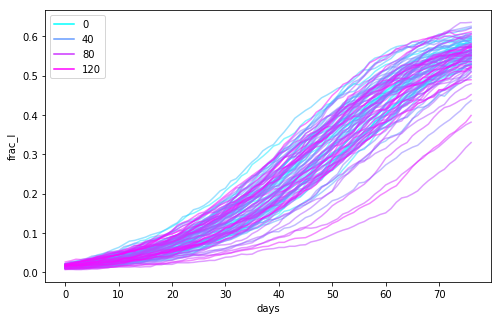

In [29]:
#x -> giorni
#y -> frac_I
#color -> location

color=df["location_id"].tolist()
color=np.array(color)

fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=df["days"],y=df["frac_I"],hue=color,ax=ax,palette="cool",alpha=.5)


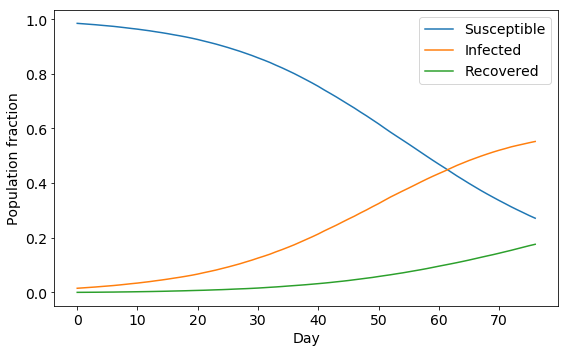

In [30]:
mean = df.groupby("days").mean()
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(mean["frac_S"], label="Susceptible")
ax.plot(mean["frac_I"], label="Infected")
ax.plot(mean["frac_R"], label="Recovered")
ax.set_xlabel("Day", fontsize=14)
ax.set_ylabel("Population fraction", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/mean_SIR.pdf")

In [31]:
beta  = []
gamma = []
for i in range(1,101):
    data = df[df["location_id"]==i]
    
    den_b = (data["frac_S"]*data["frac_I"]).sum()
    num_b = data["frac_S"].iloc[-1]-data["frac_S"].iloc[0]
    b     = -num_b/den_b
    beta.append(b)
    
    num_g = data["frac_R"].iloc[-1]
    den_g = data["frac_I"].sum()
    g     = num_g/den_g
    gamma.append(g)

mu = 7.771564124968369
sigma = 0.6655055218325029


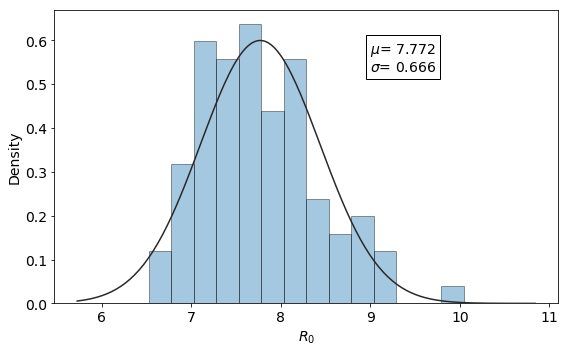

In [32]:
R0 = np.array(beta)/np.array(gamma)
mu,sigma = norm.fit(R0)
print("mu =", mu)
print("sigma =", sigma)

legend="$\mu$= {:.3f}\n$\sigma$= {:.3f}".format(mu,sigma)

fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(R0, fit=norm, kde=False, bins=14, ax=ax, norm_hist=True, kde_kws={"color":"black"}, hist_kws={"ec":'black'})
ax.set_xlabel("$R_0$", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.annotate(legend, xy=(.65,.8), xycoords='figure fraction', 
            bbox={"boxstyle":"square", "fc":"w"}, fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/R0.pdf")

(100,)
mu = 0.07507346089734118
sigma = 0.002604044987051965


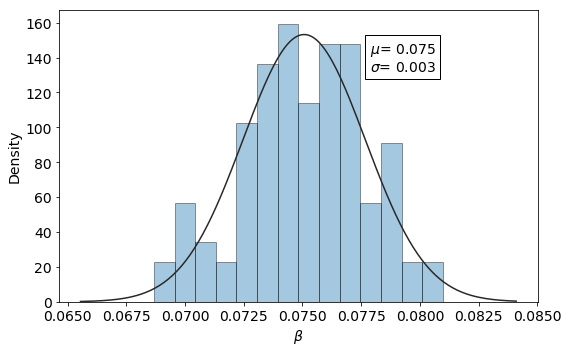

In [33]:
beta = np.array(beta)
print(beta.shape)
mu,sigma = norm.fit(beta)
print("mu =", mu)
print("sigma =", sigma)

legend="$\mu$= {:.3f}\n$\sigma$= {:.3f}".format(mu,sigma)

fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(beta, fit=norm, kde=False, bins=14, ax=ax, norm_hist=True, kde_kws={"color":"black"}, hist_kws={"ec":'black'})
ax.set_xlabel("$\\beta$", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.annotate(legend, xy=(.65,.8), xycoords='figure fraction', 
            bbox={"boxstyle":"square", "fc":"w"}, fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/beta.pdf")

mu = 0.00971910766594186
sigma = 0.0007627979098948382


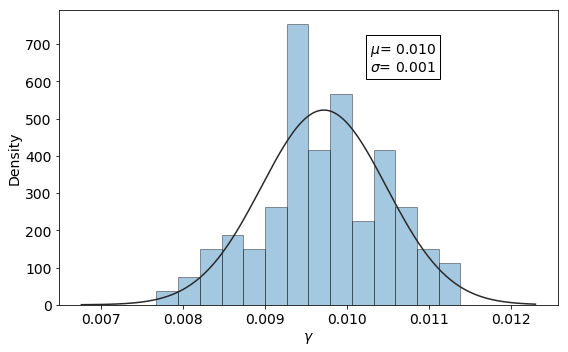

In [34]:
gamma = np.array(gamma)
mu,sigma = norm.fit(gamma)
print("mu =", mu)
print("sigma =", sigma)

legend="$\mu$= {:.3f}\n$\sigma$= {:.3f}".format(mu,sigma)

fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(gamma, fit=norm, kde=False, bins=14, ax=ax, norm_hist=True, kde_kws={"color":"black"}, hist_kws={"ec":'black'})
ax.set_xlabel("$\gamma$", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.annotate(legend, xy=(.65,.8), xycoords='figure fraction', 
            bbox={"boxstyle":"square", "fc":"w"}, fontsize=14)
fig.tight_layout()
fig.savefig("./Figure/gamma.pdf")